In [1]:
import torch
from transformers import CLIPTokenizer

/home/mlfavorfit/anaconda3/envs/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

## Device Check

In [3]:
DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

Using device: cuda


## Load CLIP Tokenizer

In [5]:
tokenizer = CLIPTokenizer("./data/vocab.json", merges_file="./data/merges.txt")

## Useful function

In [7]:
from PIL import Image
import random

In [8]:
def convert_to_random_color_tiles(colors, weights, image_size=[512,512], tile_num_per_row=4):
    # 이미지 열기
    img = Image.new('RGB', image_size)

    # 이미지 크기 가져오기
    width, height = img.size
    tile_size = (512//tile_num_per_row, 512//tile_num_per_row)

    # 타일별로 이미지를 자르고 랜덤한 색상의 타일로 대체
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # 랜덤하게 색상 섞기
            seleted_color = random.choices(colors, weights, k=1)[0]

            # 랜덤한 타일 생성
            tile = Image.new('RGB', tile_size, seleted_color)

            # 원본 이미지에 랜덤한 타일 적용
            img.paste(tile, (x, y, x + tile_size[0], y + tile_size[1]))

    # 결과 이미지 저장 또는 표시
    # img.show()
    return img

In [9]:
def center_crop_and_resize(input_path, target_size=(512, 512)):
    # 이미지 열기
    image = Image.open(input_path)

    # 이미지의 중앙을 기준으로 자르기
    width, height = image.size
    left = (width - min(width, height)) // 2
    top = (height - min(width, height)) // 2
    right = (width + min(width, height)) // 2
    bottom = (height + min(width, height)) // 2
    image = image.crop((left, top, right, bottom))

    # 리사이징
    image = image.resize(target_size, Image.ANTIALIAS)

    # 결과 저장
    return image

## Color tile based generation
---

In [11]:
diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_base.pth")
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/outpaint_v2.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")

diffusion_state_dict["lora"] = lora_state_dict

In [12]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_controlnet":True, "controlnet_scale":1.0, "is_lora":True, "lora_scale":0.3}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict)

models.update(controlnet)

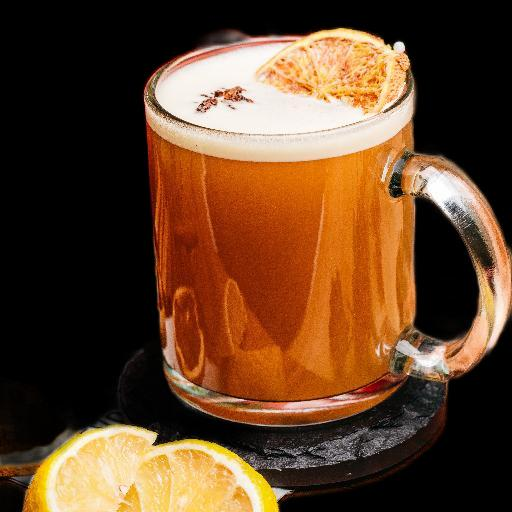

In [13]:
from PIL import Image

control_image = Image.open("./images/object_colortile/test5.jpg").convert("RGB")
control_image = control_image.resize((512,512))
control_image

Settings -> Mode=fast, Device=cuda, Torchscript=disabled


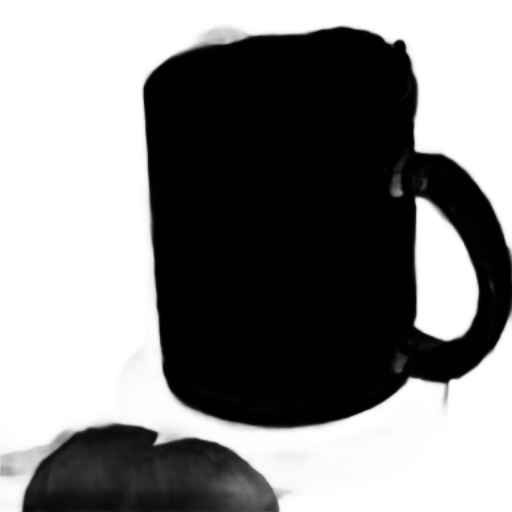

In [30]:
from transparent_background import Remover
import numpy as np
from PIL import Image

remover = Remover(mode="fast", device="cuda")
mask = remover.process(control_image, type="map")
mask_np = 255 - np.array(mask)
mask = Image.fromarray(mask_np)
mask

100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


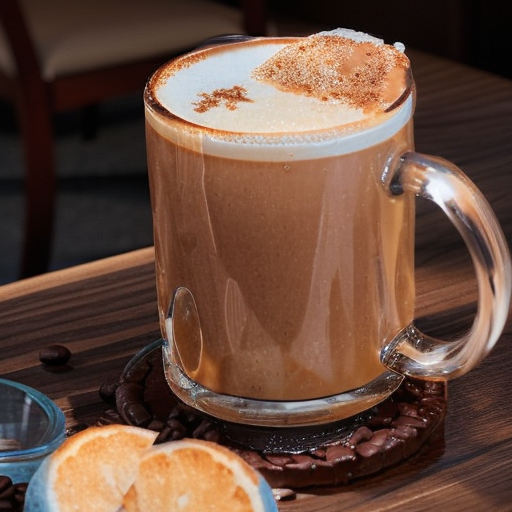

In [27]:
from pipelines.pipline_default_controlnet import generate
target_prompt = "coffee glass cup"

output_image = generate(
    prompt=f"professional photography, natural shadow, {target_prompt}, realistic, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=control_image,
    control_image=control_image,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=1.0,
    models=models,
    seed=None,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer
)

Image.fromarray(output_image)

In [31]:
import cv2
def make_canny_condition(image, min=100, max=200):
    image = np.array(image)
    image = cv2.Canny(image, min, max)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    image = Image.fromarray(image)
    return image


In [87]:
from utils.model_converter import convert_controlnet_model

diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_base.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/controlnet/control_v11f1e_sd15_tile.pth")

control_state_dict = convert_controlnet_model(control_state_dict)

diffusion_state_dict["lora"] = lora_state_dict

In [88]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_controlnet":True, "controlnet_scale":1.0, "is_lora":True, "lora_scale":1.0}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict)

models.update(controlnet)

In [ ]:
from pipelines.pipeline_inpainting_controlnet import generate

output_image = generate(
    prompt=f"professional photography, natural shadow, {target_prompt}, realistic, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=None,
    mask_image=mask,
    control_image=control_image,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=0.8,
    models=models,
    seed=42,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer
)

Image.fromarray(output_image)